# Overview

This tutorial uses the iowa liquor sales data which has about 24 million rows. The goal of this notebook given a liquor"s:
* pack size(#bottle per pack)
* retail cost per bottle
* quantity sold

predict it"s future sales price based on the previous years sales data using a tree based ML estimators: Random Forest


In [ ]:
%%capture

# Installing the required libraries:
!pip install matplotlib pandas scikit-learn tensorflow pyarrow tqdm
!pip install google-cloud-bigquery google-cloud-bigquery-storage
!pip install flake8 pycodestyle pycodestyle_magic
!pip install scikit-plot

In [ ]:
# import Classic ML
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Third Party Libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Configurations
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configurations

Let's make sure we enter the name of our GCP project in the next cell.

In [ ]:
# ENTER THE GCP PROJECT HERE
gcp_project = "YOUR-GCP-PROJECT"
print(f"gcp_project is set to {gcp_project}")

gcp_project is set to gcp-public-data-contributors
The year to predict is set to 2021


In [ ]:
# ENTER YEAR TO PREDICT
YEAR_TO_PREDICT = 2021
print(f"The year to predict is set to {YEAR_TO_PREDICT}")

### Authentication

The following cell authenticates the user through [Colab](https://colab.sandbox.google.com/). If you intend to run this notebook elsewhere, you will need to change the authentication code in the next cell accordingly.

In [ ]:
from google.colab import auth
print("Authenticating in Colab")
auth.authenticate_user()
print("Authenticated")

Authenticating in Colab
Authenticated


## Data Preparation

Query the Data

>For consistency and uniqueness of values, I will format the strings in city and category_name columns to lowercase. (e.g Davenport, DAVENPORT, davenport, should not be taken as differents city names). Making also sure there is no Nan values in the dataset

In [ ]:
# Pulling 20% of the data
query = """
  SELECT
    date, LOWER(city) AS city, LOWER(category_name) AS category_name,
    pack,state_bottle_retail, bottles_sold, sale_dollars
  FROM
    `bigquery-public-data.iowa_liquor_sales.sales` TABLESAMPLE SYSTEM (20 PERCENT)
  WHERE city IS NOT NULL
  AND category_name IS NOT NULL
  AND pack IS NOT NULL
  AND bottles_sold IS NOT NULL
  AND sale_dollars IS NOT NULL
  AND state_bottle_retail IS NOT NULL;
"""

In [ ]:
bqclient = bigquery.Client(project=gcp_project)
dataframe = bqclient.query(query).result().to_dataframe()

## Check the Dataframe


> Let"s look at the first 5 rows of the dataset

In [ ]:
dataframe.head()

,date,city,category_name,pack,state_bottle_retail,bottles_sold,sale_dollars
0,2017-08-28,des moines,straight rye whiskies,6,27.14,60,1628.40
1,2012-10-05,boone,decanters & specialty packages,4,46.50,8,372.00
2,2014-10-07,vinton,cinnamon schnapps,12,8.45,36,304.20
3,2019-08-26,cedar rapids,triple sec,12,3.63,48,174.24
4,2018-10-01,davenport,gold rum,6,11.76,30,352.80



> Next, we will get some basic information about the dataset

In [ ]:
# Exploring the categorical data
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4261379 entries, 0 to 4261378
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date                 object 
 1   city                 object 
 2   category_name        object 
 3   pack                 int64  
 4   state_bottle_retail  float64
 5   bottles_sold         int64  
 6   sale_dollars         float64
dtypes: float64(2), int64(2), object(3)
memory usage: 227.6+ MB


### Process the Dataframe

> Convert the date column from object dtype to datetime  tranform the entries to extract the month and year. then drop original date feature

In [ ]:
dataframe["date"] = dataframe["date"].astype("datetime64[ns]")
# Extracting the year and month from datetime object for manipulation
dataframe["year"] = dataframe["date"].dt.year
dataframe["month"] = dataframe["date"].dt.month

# Drop original date column
del dataframe["date"]

> Since categorical data such as the liquor"s category_name and the city  will not help in our prediction using the Random Forest estimator, I will drop those features and eliminate the need for doing lot of data engineering

In [ ]:
# Delete orginal category_name column
del dataframe["city"]
del dataframe["category_name"]

## Splitting data based on Year

> First looking at the relationship between year and sales, we can see that there is direct impact of the year on the sale value of the liquor

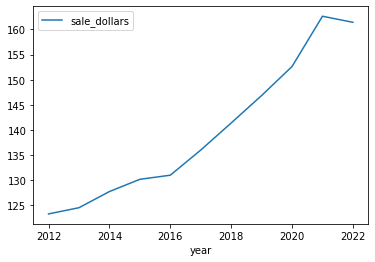

In [ ]:
year_df = dataframe[["year", "sale_dollars"]].groupby("year").mean()
year_df.plot();

> Looking at the bar plot we can also see the same results. This will inform how I divide my data

Text(0.5, 1.0, 'Count for Year')

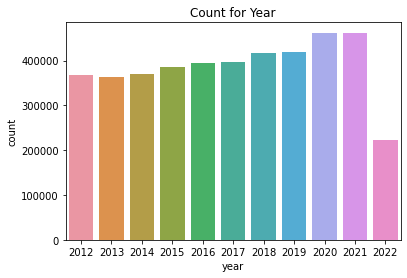

In [ ]:
# Taking a look at the distribution of the years visually
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x="year", data=dataframe)
plt.title("Count for Year")


  *   The data from 2012 to 2020 will serve as Training
  * Testing will be performed on the data from 2021








In [ ]:
# Spliting the data.
train = dataframe[dataframe["year"] < YEAR_TO_PREDICT]
test = dataframe[dataframe["year"] == YEAR_TO_PREDICT]

> Separting Input features from Target features in both the training data and the testing data

In [ ]:
# Training data
Y_train = train["sale_dollars"]
X_train = train.drop("sale_dollars", axis=1)

# Test Data
Y_test = test["sale_dollars"]
X_test = test.drop("sale_dollars", axis=1)

## Train and Predict




 > Training with Random Forest

In [ ]:
randf_estimator = RandomForestRegressor()
# Train
randf_estimator.fit(X_train, Y_train)
# Predict
y_pred = randf_estimator.predict(X_test)

>Predictions & Accuracy of our model

In [ ]:
print("Scores on the test dataset\n")
# Test set predictions
acc_test = round(np.float64(r2_score(Y_test, y_pred) * 100), 2)
print(f"test r2_score is:    {acc_test}%")
print(f"test abs mean error: {round(mean_absolute_error(Y_test, y_pred), 2)}")
print(f"test RMSE:           {round(np.sqrt(mean_squared_error(Y_test, y_pred)), 2)}")

Scores on the test dataset

test r2_score is:    95.11%
test abs mean error: 1.87
test RMSE:           136.96


In [ ]:
print("Predictions on the test dataset\n")
# Printing the results for our test dataset
print("==========================================================")
y_pred = np.round(np.float64(y_pred), 2)
test_diff = (Y_test - y_pred) / Y_test
predictions = pd.DataFrame({"Predicted Price": y_pred, "Actual Price": Y_test, "Difference": test_diff})
predictions.head(10)

Predictions on the test dataset



,Predicted Price,Actual Price,Difference
21,29.22,29.22,0.000000
36,436.66,436.80,0.000321
37,102.96,102.96,0.000000
46,337.50,337.50,0.000000
64,1583.15,1579.50,-0.002311
74,3256.80,3256.80,0.000000
97,9.74,9.74,0.000000
143,2249.99,2250.00,0.000004
144,435.60,435.60,0.000000
145,189.00,189.00,0.000000


## Feature Importance Plotting

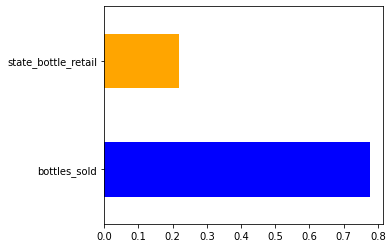

In [ ]:
colors = ["blue", "orange"]
plt.subplots(figsize=(5, 4))
feat_importances = pd.Series(randf_estimator.feature_importances_, index=X_train.columns)
feat_importances.nlargest(2).plot(kind="barh", color=colors);

As we can see from the plot above, the prediction was mostly influenced by the number bottles sold, then cost that state paid per bottle to the maker of the liquor.

This conclude our tutorial. we can now predict with some confidence, how much a particular liquor is going to sell for at a given month of a future year